# 03.4 Practical Significance: When to Trust Your Results

**Chapter**: 3 - Stats Review  
**Section**: 4 - Practical Significance  
**Facure Source**: 03-Stats-Review-The-Most-Dangerous-Equation.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Statistical vs Practical](#11-statistical-vs-practical)
   - 1.2 [The Multiple Testing Problem](#12-the-multiple-testing-problem)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Effect Sizes](#21-effect-sizes)
   - 2.2 [Multiple Comparison Corrections](#22-multiple-comparison-corrections)
   - 2.3 [Power Analysis](#23-power-analysis)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Effect Size Calculation](#31-effect-size-calculation)
   - 3.2 [Multiple Testing Simulation](#32-multiple-testing-simulation)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy import stats

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding when NOT to act on statistical significance is crucial. This separates data scientists who ship real value from those who chase noise.

### 1.1 Statistical vs Practical

Facure's key insight: **Statistical significance tells you IF an effect exists. Effect size tells you if you should CARE.**

Example:
- A/B test with 10 million users
- Conversion: 2.001% vs 2.000%
- p-value: 0.001 (highly significant!)
- Effect: +0.001 percentage points

**Statistically significant? Yes. Worth shipping? Probably not.**

### 1.2 The Multiple Testing Problem

If you test 20 metrics at α = 0.05, you **expect** 1 false positive.

$$P(\text{at least one false positive}) = 1 - (1-0.05)^{20} = 0.64$$

★ Insight ─────────────────────────────────────
- Effect size (Cohen's d, lift %) matters as much as p-value
- Multiple testing inflates false positives
- Pre-registration of primary metrics prevents p-hacking
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Effect Sizes

**Cohen's d** (for continuous outcomes):

$$\boxed{d = \frac{\bar{X}_1 - \bar{X}_0}{s_{pooled}}}$$

where $s_{pooled} = \sqrt{\frac{(n_1-1)s_1^2 + (n_0-1)s_0^2}{n_1 + n_0 - 2}}$

**Interpretation**:
| d | Interpretation |
|---|----------------|
| 0.2 | Small |
| 0.5 | Medium |
| 0.8 | Large |

**Relative lift** (for conversion rates):

$$\text{Lift} = \frac{p_1 - p_0}{p_0} \times 100\%$$

### 2.2 Multiple Comparison Corrections

**Bonferroni correction**:
$$\alpha_{adj} = \frac{\alpha}{m}$$

where $m$ = number of tests. Conservative but simple.

**Benjamini-Hochberg (FDR)**:
1. Rank p-values: $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(m)}$
2. Find largest $k$ where $p_{(k)} \leq \frac{k}{m}\alpha$
3. Reject all $H_{(1)}, \ldots, H_{(k)}$

Controls FDR (expected proportion of false discoveries among rejections).

### 2.3 Power Analysis

**Power** = P(reject H₀ | H₀ is false) = 1 - β

**Required sample size** (two-sample, equal groups):

$$n = 2\left(\frac{z_{\alpha/2} + z_\beta}{d}\right)^2$$

For 80% power at α = 0.05 detecting d = 0.5:
$$n = 2\left(\frac{1.96 + 0.84}{0.5}\right)^2 \approx 64 \text{ per group}$$

---

## 3. Numeric Demonstration

### 3.1 Effect Size Calculation

In [2]:
# Load classroom data
classroom = load_facure_data('online_classroom.csv')

online = classroom.query('format_ol == 1')['falsexam']
face_to_face = classroom.query('format_ol == 0 and format_blended == 0')['falsexam']

def cohens_d(group1, group2):
    """Calculate Cohen's d effect size."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    
    # Pooled standard deviation
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2))
    
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

d = cohens_d(online, face_to_face)

print("EFFECT SIZE ANALYSIS")
print("="*50)
print(f"Mean (Online):        {np.mean(online):.2f}")
print(f"Mean (Face-to-Face):  {np.mean(face_to_face):.2f}")
print(f"Raw difference:       {np.mean(online) - np.mean(face_to_face):.2f}")
print(f"Cohen's d:            {d:.3f}")
print("-"*50)
if abs(d) < 0.2:
    print("Interpretation: Negligible effect")
elif abs(d) < 0.5:
    print("Interpretation: Small effect")
elif abs(d) < 0.8:
    print("Interpretation: Medium effect")
else:
    print("Interpretation: Large effect")

EFFECT SIZE ANALYSIS
Mean (Online):        73.64
Mean (Face-to-Face):  78.55
Raw difference:       -4.91
Cohen's d:            -0.403
--------------------------------------------------
Interpretation: Small effect


In [3]:
# Demonstrate the "big data" problem
np.random.seed(42)

# Tiny true effect
true_effect = 0.01  # 0.01 points difference

results = []
sample_sizes = [100, 1000, 10000, 100000, 1000000]

for n in sample_sizes:
    control = np.random.normal(50, 10, n)
    treatment = np.random.normal(50 + true_effect, 10, n)
    
    t_stat, p_value = stats.ttest_ind(treatment, control)
    d = cohens_d(treatment, control)
    
    results.append({
        'n': n,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'cohens_d': d,
    })

results_df = pd.DataFrame(results)

print("THE BIG DATA PROBLEM")
print("="*60)
print(f"True effect: {true_effect} (negligible)")
print("-"*60)
print(f"{'N':>10} {'P-value':>12} {'Significant':>12} {'Cohen\'s d':>12}")
print("-"*60)
for _, row in results_df.iterrows():
    sig_str = 'YES' if row['significant'] else 'no'
    print(f"{row['n']:>10,} {row['p_value']:>12.6f} {sig_str:>12} {row['cohens_d']:>12.4f}")
print("-"*60)
print("\nNote: With enough data, even meaningless effects become 'significant'!")

THE BIG DATA PROBLEM
True effect: 0.01 (negligible)
------------------------------------------------------------
         N      P-value  Significant    Cohen's d
------------------------------------------------------------
       100     0.335459           no       0.1365
     1,000     0.616003           no      -0.0224
    10,000     0.034547          YES       0.0299
   100,000     0.866584           no      -0.0008
 1,000,000     0.159395           no       0.0020
------------------------------------------------------------

Note: With enough data, even meaningless effects become 'significant'!


### 3.2 Multiple Testing Simulation

In [4]:
# Simulate the multiple testing problem
np.random.seed(42)

n_metrics = 20
n_simulations = 1000
n_samples = 100

# No true effect for any metric
false_positives = []

for _ in range(n_simulations):
    p_values = []
    for _ in range(n_metrics):
        control = np.random.normal(0, 1, n_samples)
        treatment = np.random.normal(0, 1, n_samples)  # Same distribution!
        _, p = stats.ttest_ind(treatment, control)
        p_values.append(p)
    
    # Count false positives (any p < 0.05 when ALL nulls are true)
    n_false_positives = sum(p < 0.05 for p in p_values)
    false_positives.append(n_false_positives)

# Probability of at least one false positive
p_at_least_one = np.mean([fp > 0 for fp in false_positives])

print("MULTIPLE TESTING SIMULATION")
print("="*50)
print(f"Number of metrics tested: {n_metrics}")
print(f"True effects:             NONE (all nulls are true)")
print(f"Number of simulations:    {n_simulations}")
print("-"*50)
print(f"P(at least 1 false positive): {p_at_least_one:.1%}")
print(f"Expected from theory:         {1 - (0.95)**n_metrics:.1%}")
print(f"Average false positives:      {np.mean(false_positives):.2f}")
print(f"Expected from theory:         {n_metrics * 0.05:.2f}")

MULTIPLE TESTING SIMULATION
Number of metrics tested: 20
True effects:             NONE (all nulls are true)
Number of simulations:    1000
--------------------------------------------------
P(at least 1 false positive): 65.6%
Expected from theory:         64.2%
Average false positives:      1.04
Expected from theory:         1.00


In [5]:
# Demonstrate corrections
np.random.seed(42)

# Generate p-values (some real effects, some null)
n_tests = 20
n_true_effects = 5  # First 5 have real effects

p_values = []
for i in range(n_tests):
    if i < n_true_effects:
        # Real effect (d ≈ 0.5)
        control = np.random.normal(0, 1, 100)
        treatment = np.random.normal(0.5, 1, 100)
    else:
        # No effect
        control = np.random.normal(0, 1, 100)
        treatment = np.random.normal(0, 1, 100)
    
    _, p = stats.ttest_ind(treatment, control)
    p_values.append(p)

p_values = np.array(p_values)

# Apply corrections
alpha = 0.05

# Uncorrected
sig_uncorrected = p_values < alpha

# Bonferroni
bonferroni_alpha = alpha / n_tests
sig_bonferroni = p_values < bonferroni_alpha

# Benjamini-Hochberg (FDR)
from scipy.stats import false_discovery_control
# Manual BH implementation
sorted_idx = np.argsort(p_values)
sorted_p = p_values[sorted_idx]
bh_threshold = np.arange(1, n_tests+1) / n_tests * alpha
bh_accept = sorted_p <= bh_threshold
# Find the largest k where p_(k) <= k/m * alpha
if bh_accept.any():
    k = np.max(np.where(bh_accept)[0]) + 1
    sig_bh = np.zeros(n_tests, dtype=bool)
    sig_bh[sorted_idx[:k]] = True
else:
    sig_bh = np.zeros(n_tests, dtype=bool)

print("MULTIPLE COMPARISON CORRECTIONS")
print("="*60)
print(f"Total tests:          {n_tests}")
print(f"True effects:         {n_true_effects} (tests 1-5)")
print(f"Null effects:         {n_tests - n_true_effects} (tests 6-20)")
print("-"*60)
print(f"{'Method':<20} {'Rejections':>12} {'True Pos':>10} {'False Pos':>10}")
print("-"*60)

for name, sig in [('Uncorrected', sig_uncorrected), 
                   ('Bonferroni', sig_bonferroni),
                   ('Benjamini-Hochberg', sig_bh)]:
    true_pos = sig[:n_true_effects].sum()
    false_pos = sig[n_true_effects:].sum()
    print(f"{name:<20} {sig.sum():>12} {true_pos:>10} {false_pos:>10}")

MULTIPLE COMPARISON CORRECTIONS
Total tests:          20
True effects:         5 (tests 1-5)
Null effects:         15 (tests 6-20)
------------------------------------------------------------
Method                 Rejections   True Pos  False Pos
------------------------------------------------------------
Uncorrected                     6          5          1
Bonferroni                      4          4          0
Benjamini-Hochberg              4          4          0


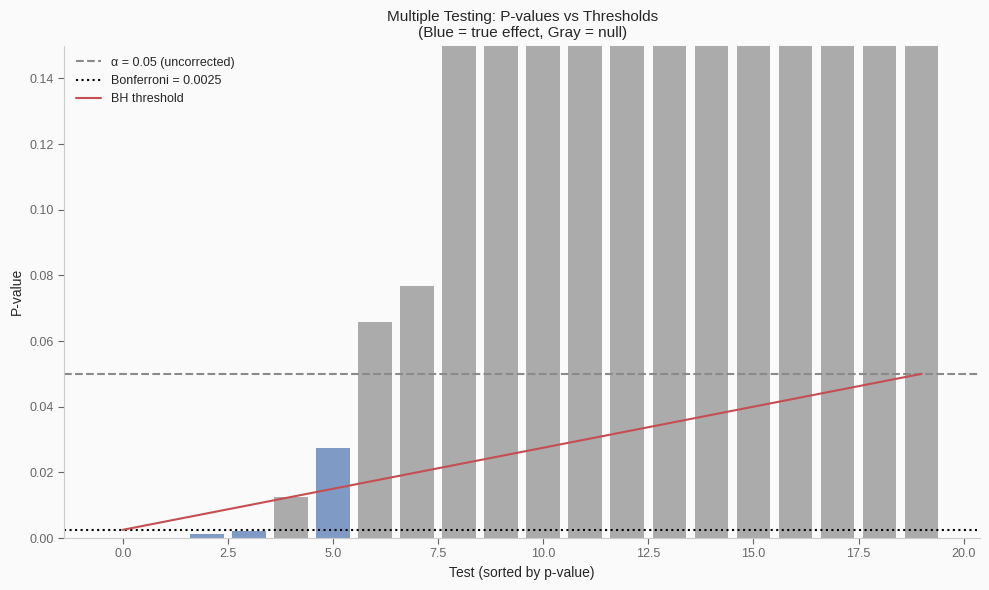

In [6]:
# Visualize p-value distribution
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

# Sort by p-value for visualization
sorted_idx = np.argsort(p_values)
sorted_p = p_values[sorted_idx]

colors = [TUFTE_PALETTE['treatment'] if i < n_true_effects else TUFTE_PALETTE['secondary'] 
          for i in sorted_idx]

bars = ax.bar(range(n_tests), sorted_p, color=colors, alpha=0.7)

# Thresholds
ax.axhline(0.05, color=TUFTE_PALETTE['control'], linestyle='--', 
           label=f'α = 0.05 (uncorrected)')
ax.axhline(bonferroni_alpha, color='black', linestyle=':', 
           label=f'Bonferroni = {bonferroni_alpha:.4f}')

# BH line
bh_line = np.arange(1, n_tests+1) / n_tests * alpha
ax.plot(range(n_tests), bh_line, color=TUFTE_PALETTE['effect'], 
        linestyle='-', label='BH threshold')

ax.set_xlabel('Test (sorted by p-value)')
ax.set_ylabel('P-value')
ax.set_title('Multiple Testing: P-values vs Thresholds\n(Blue = true effect, Gray = null)')
ax.legend(frameon=False, loc='upper left')
ax.set_ylim(0, 0.15)

plt.tight_layout()
plt.show()

---

## 4. Implementation

```python
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Effect size
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

# Multiple testing corrections
reject, p_adj, _, _ = multipletests(p_values, method='bonferroni')
reject, p_adj, _, _ = multipletests(p_values, method='fdr_bh')

# Power analysis
from statsmodels.stats.power import TTestIndPower
power = TTestIndPower()
n = power.solve_power(effect_size=0.5, alpha=0.05, power=0.8)
```

---

## 5. Interview Appendix

**Q1 (Netflix, Spotify)**: *"What's the difference between statistical and practical significance?"*

<details><summary>Solution</summary>

**Statistical significance**: p < α (usually 0.05). Answers: "Is the effect real?"

**Practical significance**: Effect size is meaningful. Answers: "Should we care?"

Key insight: With large n, even tiny effects become statistically significant. A 0.001% conversion lift with p < 0.001 might not justify the engineering cost to ship.

**In practice**: Report both p-value AND effect size (Cohen's d, lift %). Let stakeholders judge practical significance based on business context.

</details>

**Q2 (Uber, Lyft)**: *"You ran 20 A/B tests and 3 were significant at p < 0.05. How do you interpret this?"*

<details><summary>Solution</summary>

**Multiple testing problem**: At α = 0.05, we expect 1 false positive per 20 tests (20 × 0.05 = 1).

**Finding 3 significant results** could mean:
- 2-3 real effects + 0-1 false positives, OR
- 1 real effect + 2 false positives

**What to do**:
1. Apply correction (Bonferroni: α_adj = 0.05/20 = 0.0025)
2. Check which of the 3 survive correction
3. For borderline cases, consider effect sizes and pre-registration status
4. Consider replication for important findings

</details>

**Q3 (Stripe, Airbnb)**: *"How would you design an experiment to have 80% power to detect a 5% lift in conversion?"*

<details><summary>Solution</summary>

**Power analysis framework**:

1. **Define parameters**:
   - Baseline conversion: p₀ (e.g., 10%)
   - Minimum detectable effect: 5% lift → p₁ = 10.5%
   - α = 0.05, power = 0.80

2. **Calculate effect size**:
   - Cohen's h = 2*arcsin(√p₁) - 2*arcsin(√p₀) ≈ 0.016
   - This is a very small effect!

3. **Required sample size**:
   - n ≈ 2 × ((1.96 + 0.84) / 0.016)² ≈ 61,000 per group
   - Total: ~122,000 users

4. **Practical considerations**:
   - How long to accumulate 122k users?
   - Is 5% lift worth the wait?
   - Consider sequential testing to stop early

**Code**: `from statsmodels.stats.power import NormalIndPower`

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 3.

[^2]: Cohen, J. (1988). *Statistical Power Analysis for the Behavioral Sciences*. Lawrence Erlbaum.

[^3]: Benjamini, Y., & Hochberg, Y. (1995). Controlling the false discovery rate: a practical and powerful approach to multiple testing. *JRSS B*, 57(1), 289-300.

[^4]: Kohavi, R., Tang, D., & Xu, Y. (2020). *Trustworthy Online Controlled Experiments: A Practical Guide to A/B Testing*. Cambridge University Press.